# TLDR

This notebook explores running preferential BO on the shapes dataset. 

## Summary of the PBO procedure:
- create outcome function (Image) and utility function (area, or fancier versions)
- generate initial data of (image 1, image 2, preference)
- train a utility model
- iteratively use EUBO to generate new comparisons, expand data, refit utility model; generate image that maximizes utility; plot the utility of the candidate over comparisons

Caveats:
- bounds

Ryan's notebook: https://github.com/zyyjjj/low_rank_BOPE/blob/ryan-dev/notebooks/GitHub%20PCA-BO%20for%20Shapes%20Dataset.ipynb


In [78]:
%load_ext autoreload
%autoreload 2

import itertools
import pickle
import re
import warnings
from collections import defaultdict
from dataclasses import asdict, dataclass
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import torch 

warnings.filterwarnings("ignore")

import sys
sys.path.append('..')
sys.path.append('/home/yz685/low_rank_BOPE')
sys.path.append('/home/yz685/low_rank_BOPE/low_rank_BOPE')

from botorch.models import PairwiseGP, PairwiseLaplaceMarginalLogLikelihood
from botorch.models.transforms.input import ChainedInputTransform
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.preference import AnalyticExpectedUtilityOfBestOption
from botorch.optim.optimize import optimize_acqf



from low_rank_BOPE.bope_class import BopeExperiment
from low_rank_BOPE.test_problems.shapes import AreaUtil, LargestRectangleUtil, GradientAwareAreaUtil, Image
from low_rank_BOPE.src.transforms import InputCenter, PCAInputTransform
from low_rank_BOPE.src.pref_learning_helpers import gen_comps



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
N_PIXELS = 8

problem = Image(num_pixels=N_PIXELS)

util_func = AreaUtil() # would binarize the pixels by default
# util_func = LargestRectangleUtil(image_shape=(N_PIXELS, N_PIXELS))
# util_func = GradientAwareAreaUtil(penalty_param=0.5, image_shape=(N_PIXELS, N_PIXELS))

exp = BopeExperiment(
    problem = problem, 
    util_func=util_func, 
    methods=["st","pca"],
    pe_strategies=["Random-f"],
    trial_idx = 31,
    pca_var_threshold = 0.9,
    output_path = "/home/yz685/low_rank_BOPE/experiments/shapes/" + \
        f"{N_PIXELS}by{N_PIXELS}/")


exp.generate_random_experiment_data(n=256, compute_util = True)


BopeExperiment settings:  {'pca_var_threshold': 0.9, 'initial_experimentation_batch': 16, 'n_check_post_mean': 20, 'every_n_comps': 3, 'verbose': True, 'dtype': torch.float64, 'noise_std': 0.01, 'num_restarts': 20, 'raw_samples': 128, 'batch_limit': 4, 'sampler_num_outcome_samples': 64, 'maxiter': 1000, 'latent_dim': None, 'min_stdv': 100000, 'true_axes': None}
self.methods,  ['pca', 'st']


In [93]:
train_Y = exp.Y
train_comps = exp.comps

pixel_bounds = torch.cat(
    (torch.zeros(N_PIXELS*N_PIXELS).unsqueeze(0), torch.ones(N_PIXELS*N_PIXELS).unsqueeze(0)), 
    dim=0
)

In [86]:
# learn PCA from train_Y

# how to handle centering? 
# need centering when learning PCA
# but when appplying it as input transform
# what happens if we don't center?
# seeems like the GP would just have a nonzero mean, but shouldn't change anything else

def fit_pca(train_Y, var_threshold=0.9, weights = None):

    # unweighted pca
    if weights == None:
        U, S, V = torch.svd(train_Y - train_Y.mean(dim=0))

    # weighted pca
    else:
        assert weights.shape == (train_Y.shape[0], 1), \
            "weights shape does not match train_Y shape"
        assert (weights >= 0).all(), \
            "weights must be nonnegative"
            
        weighted_mean = (weights * train_Y).sum(dim=0) / weights.sum(0)
        train_Y_centered = train_Y - weighted_mean
        U, S, V = torch.svd(weights * train_Y_centered)

    S_squared = torch.square(S)
    explained_variance = S_squared / S_squared.sum()

    exceed_thres = (
        np.cumsum(explained_variance) > 0.9
    )
    num_axes = len(exceed_thres) - sum(exceed_thres) + 1

    pca_axes = torch.tensor(torch.transpose(V[:, : num_axes], -2, -1), dtype = torch.double)

    return pca_axes


In [ ]:
# TODO: have a function that calculates weights based on utility values / estimates
# this can be put into src later

def compute_weights(util_vals, weights_type, **kwargs):

    # util_vals can be true utility values
    # or predicted posterior mean from current utility model

    # options for weights_type: rank_weighting as in Tripp et al. 

    if weights_type == "rank":
        k = kwargs.get("k", 10) # TODO: come back to this
        utils_argsort = np.argsort(-np.asarray(util_vals))
        ranks = np.argsort(utils_argsort)
        weights = 1 / (k * len(util_vals) + ranks)

    elif weights_type == "power":
        pass
        # rough idea: apply a power transformation to util_vals, make sure they are nonnegative

    
    return weights

    




In [139]:
# torch.linalg.eig(torch.cov(train_Y.T))[1]
# U, _, _ = torch.svd((train_Y - train_Y.mean(dim=0)).T)

tensor([[ 0.0233+0.j,  0.0634+0.j, -0.0186+0.j,  ...,  0.0705+0.j,  0.0120+0.j,
         -0.0010+0.j],
        [ 0.0517+0.j,  0.0938+0.j, -0.0367+0.j,  ...,  0.0334+0.j, -0.1840+0.j,
          0.0549+0.j],
        [ 0.0764+0.j,  0.0861+0.j, -0.0666+0.j,  ..., -0.0119+0.j,  0.0947+0.j,
          0.0548+0.j],
        ...,
        [ 0.0518+0.j, -0.0997+0.j,  0.0738+0.j,  ...,  0.0068+0.j,  0.1174+0.j,
          0.0220+0.j],
        [ 0.0371+0.j, -0.0903+0.j,  0.0436+0.j,  ..., -0.0122+0.j,  0.0508+0.j,
         -0.0954+0.j],
        [ 0.0346+0.j, -0.0564+0.j,  0.0022+0.j,  ..., -0.0134+0.j, -0.1675+0.j,
          0.1135+0.j]], dtype=torch.complex128)

In [74]:
def fit_util_model(train_Y, train_comps, input_transform):

    util_model = PairwiseGP(
        datapoints=train_Y, comparisons=train_comps, input_tf = input_transform)

    mll_util = PairwiseLaplaceMarginalLogLikelihood(
        util_model.likelihood, util_model)
    fit_gpytorch_mll(mll_util)

    return util_model

In [160]:
# iteratively refit subspace, refit util model, and optimize EUBO

for i in range(10):
    
    print(f'round {i}')

    pca_axes = fit_pca(train_Y)
    pca_input_transform = ChainedInputTransform(
        **{
            "center": InputCenter(N_PIXELS * N_PIXELS),
            "pca": PCAInputTransform(axes=pca_axes),
        }
    )

    util_model = fit_util_model(train_Y=train_Y, train_comps=train_comps, input_transform=pca_input_transform)

    acqf = AnalyticExpectedUtilityOfBestOption(
        pref_model=util_model,
    ).to(torch.double) 

    cand_Y, acqf_val = optimize_acqf(
        acq_function=acqf,
        q=2,
        bounds=pixel_bounds,
        num_restarts=16,
        raw_samples=128,  
        options={"batch_limit": 4, "seed": 0},
    )

    cand_utils = util_func(cand_Y)

    cand_comps = gen_comps(cand_utils)
    train_comps = torch.cat((train_comps, cand_comps + train_Y.shape[0]))
    train_Y = torch.cat((train_Y, cand_Y))

    print(cand_utils)


# question: if pref_model is already operating on bounded outcome space, just with PCA as input transform, 
# wouldn't specifying the [0,1] box bounds already suffice? 
# so we just specify the bounds argument

# this still has the issue of clipping to bounds in the pixel space,
# later let's try computing the pc explicitly and applying inequality constraints

round 0
tensor([40., 33.])
round 1
tensor([29., 28.])
round 2
tensor([33., 32.])
round 3
tensor([34., 38.])
round 4
tensor([27., 25.])
round 5
tensor([23., 26.])
round 6
tensor([30., 38.])
round 7
tensor([34., 23.])
round 8
tensor([38., 33.])
round 9
tensor([27., 39.])


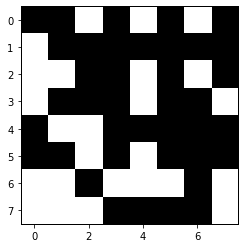

In [161]:
plt.imshow(cand_Y[1].reshape(N_PIXELS, N_PIXELS)>0.5, cmap=plt.cm.gray_r)


In [72]:
util_func(cand_Y)

tensor([[6],
        [8]])